## NEPTUNE

In [ ]:

!pip install neptune-client==0.9.1
!pip install neptune-tensorflow-keras==0.9.1

     |████████████████████████████████| 215kB 35.0MB/s 
     |████████████████████████████████| 829kB 34.6MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 174kB 48.8MB/s 
     |████████████████████████████████| 133kB 53.1MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=0f7de2222cbd713fd67860f500fa022c876578465e7d8d839b6d4e9884c7479e
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=765ac148b63be8c39e7979b0723436e487be70cc5290e016b33a5ec7bc23135a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
import neptune.new as neptune

run = neptune.init(project='', api_token='')

https://app.neptune.ai/despdair/Subtask-1/e/SUB-63


In [ ]:
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')

## DATA PROCESSING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 31.8MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [ ]:
trainDfEng =  pd.read_json("./en-train.json", lines = True)
trainDfEng.head()

Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated


,id,text,label
0,100000,Schools 'need to adopt green approach'\nPUBLIS...,0
1,100001,"IN SCHOOL\nKerber, defending Graf’s record, ge...",0
2,100002,Microsoft launches Xbox Music on Web for free\...,0
3,100003,"PUBLISHED : Sunday, 20 February, 2000, 12:00am...",0
4,100004,Stocks to bounce back: fund managers\nTNN | Se...,0


In [ ]:
testData = pd.read_json("./test.json", lines = True)
testData.head()

,id,text
0,109324,Beijing to build city's tallest building - Peo...
1,109325,Freezing in the office? Here are some fashiona...
2,109326,"UAS reopening put off by a week\nTNN | Sep 29,..."
3,109327,Millennium gets back to basics\nPUBLISHED : We...
4,109328,Pakistan's Supreme Court dismisses appeals aga...


In [ ]:
trainDfEng.drop_duplicates(subset= "text",inplace= True)

In [ ]:
trainDfEng.shape

(9319, 3)

(array([7407.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1912.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

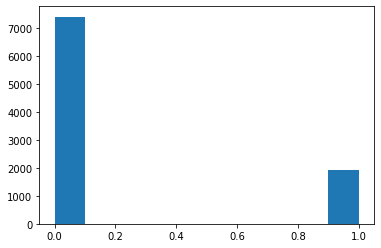

In [ ]:
plt.hist(trainDfEng["label"])

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def clean(text, stem = False):
    # Lowering letters
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z"]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
      if stem:
        word_token = lemmatizer.lemmatize(word_token, "v")

      filtered_sentence.append(word_token)
    
    # Joining words
    text = (' '.join(filtered_sentence))
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
all_cleaned_texts = np.array([clean(text) for text in trainDfEng["text"]])

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

maxlen = max([len(sent) for sent in all_encoded_texts])
all_encoded_texts = tf.keras.preprocessing.sequence.pad_sequences(all_encoded_texts, maxlen= maxlen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
def getEmbedding(mode = "GN300"):
  import multiprocessing
  import gensim
  import gensim.downloader as api

  if mode == "customTrained":
    modelW2V = gensim.models.Word2Vec(all_cleaned_texts, size= 500, min_count = 2, window = 5, sg=0, iter = 10, workers= multiprocessing.cpu_count() - 1)
  elif mode == "GN300":
    word2vec = api.load("word2vec-google-news-300")
  else:
    word2vec = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")

  num_words = len(list(tokenizer.word_index))

  embedding_matrix = np.random.uniform(-1, 1, (num_words + 1, 300))
  for word, i in tokenizer.word_index.items():
      if i < num_words:
        try:
          embedding_vector = word2vec.get_vector(word)
          if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
          else:
            embedding_matrix[i] = np.zeros((300,))
        except:
          pass

  embedding_matrix[num_words] = np.zeros((300,))
  return embedding_matrix

EMBED_MODE = "NNLM"

embedding_matrix = getEmbedding(EMBED_MODE)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, trainDfEng["label"], test_size=0.2, random_state=42)

## MODELS

In [ ]:
from sklearn.metrics import f1_score

class MacroF1Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    y_pred = self.model.predict(X_train)

    print("Train F1 Score: ", f1_score(y_train, y_pred > 0.5, average = "macro"))
    
    y_pred = self.model.predict(X_test)

    print("Train F1 Score: ", f1_score(y_test, y_pred > 0.5, average = "macro"))

In [ ]:
TRAIN_EMBED = False
DROPOUT = 0.5

def get_model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Embedding(input_dim= embedding_matrix.shape[0],
                                                                output_dim= embedding_matrix.shape[1],
                                                                weights = [embedding_matrix],
                                                                input_length= maxlen,
                                                              trainable = TRAIN_EMBED),
                                      tf.keras.layers.Conv1D(128, 3, activation= "relu", padding= "same"),
                                      tf.keras.layers.GlobalMaxPool1D(),
                                      tf.keras.layers.Dropout(DROPOUT),
                                      tf.keras.layers.Dense(64, activation= "relu", kernel_regularizer= tf.keras.regularizers.l2(1e-4)),
                                      tf.keras.layers.Dense(1, activation= "sigmoid")
                                      ]
  )

  model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy', "AUC"])
  
  return model

In [ ]:
model = get_model()

PARAMS = {"train_embed": TRAIN_EMBED, "embedding": EMBED_MODE, "dropout": DROPOUT, "batch_size": 16, "weights": 1}

run["model_name"] = "CNN"
run["hyper-parameters"] = PARAMS

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size= 16, epochs= 100, callbacks= [
    tf.keras.callbacks.EarlyStopping(patience= 3, verbose = 1, monitor = "val_auc", mode= "max"), 
    tf.keras.callbacks.ModelCheckpoint(monitor = "val_loss", filepath = "./modelcnn", save_best_only = True, save_weights_only = True),
    neptune_cbk
])

Epoch 1/100


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7f8acb441320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

466/466 [==============================] - 44s 23ms/step - loss: 0.6336 - accuracy: 0.7429 - auc: 0.5715 - val_loss: 0.3986 - val_accuracy: 0.8503 - val_auc: 0.8499
Epoch 2/100
466/466 [==============================] - 10s 21ms/step - loss: 0.4203 - accuracy: 0.8236 - auc: 0.7911 - val_loss: 0.3563 - val_accuracy: 0.8702 - val_auc: 0.8762
Epoch 3/100
466/466 [==============================] - 10s 21ms/step - loss: 0.3606 - accuracy: 0.8537 - auc: 0.8643 - val_loss: 0.3401 - val_accuracy: 0.8691 - val_auc: 0.8845
Epoch 4/100
466/466 [==============================] - 10s 22ms/step - loss: 0.3285 - accuracy: 0.8722 - auc: 0.8798 - val_loss: 0.3226 - val_accuracy: 0.8777 - val_auc: 0.8951
Epoch 5/100
466/466 [==============================] - 10s 22ms/step - loss: 0.3023 - accuracy: 0.8841 - auc: 0.8988 - val_loss: 0.3150 - val_accuracy: 0.8739 - val_auc: 0.8942
Epoch 6/100
466/466 [==============================] - 10s 22ms/step - loss: 0.2712 - accuracy: 0.8966 - auc: 0.9235 - val_loss

In [ ]:
model.load_weights("./modelcnn")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test) > 0.5, digits= 4))

              precision    recall  f1-score   support

           0     0.9036    0.9618    0.9318      1491
           1     0.7942    0.5898    0.6769       373

    accuracy                         0.8873      1864
   macro avg     0.8489    0.7758    0.8043      1864
weighted avg     0.8817    0.8873    0.8808      1864



In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))

In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)

bestT = 0
bestF1 = 0
for t in thresholds:
  f1 = f1_score(y_test, y_pred > t)
  if f1 > bestF1:
    bestF1 = f1
    bestT = t

print("Best threshold: ", bestT)
print(classification_report(y_test, model.predict(X_test) > bestT))

Best threshold:  0.40183583
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1491
           1       0.78      0.65      0.71       373

    accuracy                           0.89      1864
   macro avg       0.85      0.80      0.82      1864
weighted avg       0.89      0.89      0.89      1864



In [ ]:
y_pred = model.predict_proba(X_test)

import pickle

with open("./ModelResults/" + "CNN-NNLM-TRAINED" + ".pkl", "wb") as fout:
  pickle.dump(y_pred, fout)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
